# 1. SETUP

## 1.1 Install dependencies

In [ ]:
!pip install tensorflow==2.12.1 opencv-python matplotlib

In [ ]:
pip install tensorflow

In [ ]:
pip install opencv-python

## 1.2 import dependencies

In [59]:
# import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [60]:
# import tensorflow dependecies

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [61]:
# Model(inputs=[inputimage, verificationimage] ,outputs=[1,0])

## 1.3 Set GPU growth

In [3]:
# avoid oom errors by setting GPU memory consumption Growth
# basically tensorflow allocate memory dynamically

gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## 1.4 Create Folder Structures

In [62]:
# setup paths
POS_PATH= os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH= os.path.join('data','anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and anchors

## 2.1 Untar Labelled faces in the Wild Dataset

In [6]:
# http://vis-www.cs.umass.edu./lfw/

In [ ]:
# uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

## 2.2 Collect Positive and Anchor classes

In [63]:
# import uuid library to generate unique names
import uuid

In [64]:
# establish a connection to webcam
cap=cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Error: Unable to open webcam")
    exit()

while cap.isOpened():
    ret,frame=cap.read()
    
    # cut down frame to 250x250 px
    frame=frame[120:120+250,200:200+250,:]
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create the unique file path
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)
        
    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create the unique file path
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)
    
    # show image back to screen
    cv2.imshow('Image Collection',frame)
    
    # breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# release connection from webcam
cap.release()
# close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess images

## 3.1 Get image directories

In [65]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [66]:
dir_test = anchor.as_numpy_iterator()

In [67]:
print(dir_test.next())

b'data\\anchor\\c304b14d-f5cd-11ee-847c-f6b82506e283.jpg'


## 3.2 Preprocessing - scale and resize

In [68]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [69]:
img = preprocess('data\\anchor\\a473ea7d-f3b8-11ee-b6f8-f6b82506e283.jpg')

In [70]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [71]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [72]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [73]:
samples = data.as_numpy_iterator()

In [74]:
example = samples.next()
example

(b'data\\anchor\\ba402d34-f5cd-11ee-a19c-f6b82506e283.jpg',
 b'data\\positive\\536baf36-f5cd-11ee-bad6-f6b82506e283.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [75]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [76]:
res = preprocess_twin(*example)

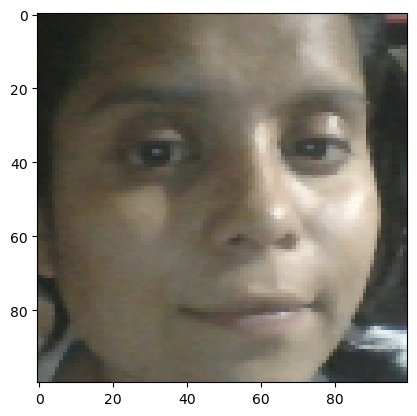

In [77]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [78]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [79]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [80]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [81]:
inp = Input(shape=(100,100,3), name='input_image')

In [82]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [83]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [84]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [85]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [86]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [87]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [88]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [90]:
embedding = make_embedding()

In [91]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [92]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [93]:
l1 = L1Dist()

In [94]:
l1

<L1Dist name=l1_dist_3, built=False>

## 4.3 Make Siamese Model

In [95]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [96]:
siamese_model=make_siamese_model()

In [97]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [99]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [100]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints¶

In [101]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [102]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y= batch_1[2]
y

array([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

In [126]:
@tf.function
def train_step(batch):
    
    # record all of the operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative images
        X=batch[:2]
        # Get Label
        y=batch[2]
        
        # forward pass
        yhat=siamese_model(X,training=True)
        # Calculate loss
        loss=binary_cross_loss(y,yhat)
    
    # calculate gradient
    grad=tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model
    # The optimizer here is calculating the new weights using Adam's optimisation algorithm , a variant of gradient descent
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

## 5.4 Build Training Loop

In [127]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [128]:
EPOCHS = 30

In [129]:
train(train_data, EPOCHS)


 Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2745s 99s/step

 Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1031s 38s/step

 Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1070s 39s/step

 Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1058s 39s/step

 Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1486s 56s/step

 Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2816s 104s/step

 Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2178s 82s/step

 Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1398s 52s/step

 Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 980s 36s/step

 Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1039s 39s/step

 Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1052s 39s/step

 Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1070s 39s/step

 Epoch 13/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1197s 45s/step

 Epoch 14/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2044s 77s/step

 Epoch 15/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1021s 38s/step

 Epoch 16/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1166s 43s/step

 Epoch 17/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1160s 43s/step

 Epoch 18/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1201s 45s/step



# 6. Evaluate Model

## 6.1 Import Metrics

In [130]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [131]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [132]:
# Make predictions
y_pred = siamese_model.predict([test_input, test_val])
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


array([[1.98214824e-04],
       [9.99941289e-01],
       [9.99999821e-01],
       [8.92945809e-06],
       [1.00000000e+00],
       [2.98834806e-07],
       [9.99999583e-01],
       [1.00000000e+00],
       [9.99923646e-01],
       [9.96378064e-01],
       [9.99838889e-01],
       [1.05572674e-07],
       [1.16079445e-06],
       [1.06662110e-05],
       [7.18412593e-07],
       [9.99995351e-01]], dtype=float32)

In [139]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_pred ]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]

In [140]:
y_true

array([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [141]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

1.0

In [142]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

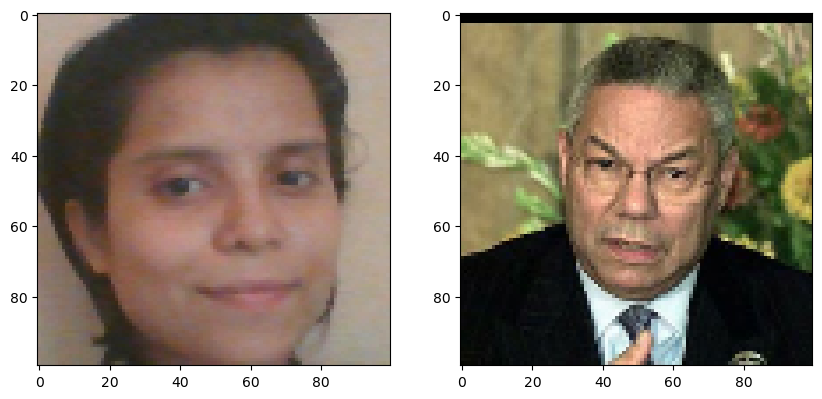

In [143]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [145]:
# Save weights
siamese_model.save('my_model.keras')

In [146]:
L1Dist

__main__.L1Dist

In [147]:
# Reload model 
model = tf.keras.models.load_model('my_model.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [148]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


array([[1.98214824e-04],
       [9.99941289e-01],
       [9.99999821e-01],
       [8.92945809e-06],
       [1.00000000e+00],
       [2.98834806e-07],
       [9.99999583e-01],
       [1.00000000e+00],
       [9.99923646e-01],
       [9.96378064e-01],
       [9.99838889e-01],
       [1.05572674e-07],
       [1.16079445e-06],
       [1.06662110e-05],
       [7.18412593e-07],
       [9.99995351e-01]], dtype=float32)

In [149]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_6 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [150]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00a54f5f-f3b8-11ee-ac68-f6b82506e283.jpg',
 '00c3cfc1-f3b8-11ee-a898-f6b82506e283.jpg',
 '01b0db69-f3b8-11ee-bff2-f6b82506e283.jpg',
 '01d5eab6-f3b9-11ee-bcf3-f6b82506e283.jpg',
 '04a4f6b9-f3b8-11ee-b3c9-f6b82506e283.jpg',
 '04e63218-f5cd-11ee-8093-f6b82506e283.jpg',
 '05f5513a-f3b8-11ee-8f5a-f6b82506e283.jpg',
 '1b5795a5-f5cb-11ee-8e82-f6b82506e283.jpg',
 '396d9fef-f3b8-11ee-8768-f6b82506e283.jpg',
 '3a4cea51-f5cb-11ee-9619-f6b82506e283.jpg',
 '3acbde14-f5cb-11ee-a42b-f6b82506e283.jpg',
 '483eb788-f3b8-11ee-97c6-f6b82506e283.jpg',
 '4ad44756-f3b8-11ee-a495-f6b82506e283.jpg',
 '4b117382-f3b8-11ee-90d1-f6b82506e283.jpg',
 '4b5dd9d3-f3b8-11ee-8838-f6b82506e283.jpg',
 '4cc88650-f3b8-11ee-91d8-f6b82506e283.jpg',
 '4d3a496f-f3b8-11ee-92fa-f6b82506e283.jpg',
 '4d937c0c-f3b8-11ee-917f-f6b82506e283.jpg',
 '5dc75514-f5cd-11ee-9b02-f6b82506e283.jpg',
 '5df52213-f5cd-11ee-8537-f6b82506e283.jpg',
 '5e8dd799-f5cd-11ee-8a0c-f6b82506e283.jpg',
 '5e9a8936-f5cd-11ee-ae53-f6b82506e283.jpg',
 '649f87e6

In [151]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [152]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00a54f5f-f3b8-11ee-ac68-f6b82506e283.jpg
application_data\verification_images\00c3cfc1-f3b8-11ee-a898-f6b82506e283.jpg
application_data\verification_images\01b0db69-f3b8-11ee-bff2-f6b82506e283.jpg
application_data\verification_images\01d5eab6-f3b9-11ee-bcf3-f6b82506e283.jpg
application_data\verification_images\04a4f6b9-f3b8-11ee-b3c9-f6b82506e283.jpg
application_data\verification_images\04e63218-f5cd-11ee-8093-f6b82506e283.jpg
application_data\verification_images\05f5513a-f3b8-11ee-8f5a-f6b82506e283.jpg
application_data\verification_images\1b5795a5-f5cb-11ee-8e82-f6b82506e283.jpg
application_data\verification_images\396d9fef-f3b8-11ee-8768-f6b82506e283.jpg
application_data\verification_images\3a4cea51-f5cb-11ee-9619-f6b82506e283.jpg
application_data\verification_images\3acbde14-f5cb-11ee-a42b-f6b82506e283.jpg
application_data\verification_images\483eb788-f3b8-11ee-97c6-f6b82506e283.jpg
application_data\verification_images\4ad44756-f3b8-11ee-a495-f6b

In [153]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV real time verification

In [154]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

In [155]:
np.sum(np.squeeze(results) > 0.9)

50

In [ ]:
32/50

In [156]:
results

[array([[0.9999949]], dtype=float32),
 array([[0.9999761]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.99999815]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[0.99852145]], dtype=float32),
 array([[0.9999923]], dtype=float32),
 array([[0.9997105]], dtype=float32),
 array([[0.9899265]], dtype=float32),
 array([[0.974229]], dtype=float32),
 array([[0.99807644]], dtype=float32),
 array([[0.99995065]], dtype=float32),
 array([[0.9999755]], dtype=float32),
 array([[0.9999562]], dtype=float32),
 array([[0.9999098]], dtype=float32),
 array([[0.9998563]], dtype=float32),
 array([[0.99974597]], dtype=float32),
 array([[0.9997583]], dtype=float32),
 array([[0.999998]], dtype=float32),
 array([[0.9999982]], dtype=float32),
 array([[0.9999985]], dtype=float32),
 array([[0.99999875]], dtype=float32),
 array([[0.99999785]], dtype=float32),
 array([[0.9999985]], dtype=float32),
 array([[0.9999986]], dtype=float32),
 array([[0.9999986]], dtype=float32),
 array